In [1]:
from typing import List, Tuple

import numpy
import random
import torch
import scipy.stats as sts
from scipy.stats import lognorm
from tqdm import tqdm as tqdm

# BED imports
from modelcomp.networks.fullyconnected import FullyConnected
from modelcomp.networks.summstats import NeuralSummStats, CAT_NSS
from modelcomp.simulators.bandits import simulate_bandit_batch, sim_bandit_prior
from modelcomp.utils.utils_simulation_study import *

# matplotlib imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rc
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.rcParams.update({'font.size': 16})
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
device = torch.device('cpu')

# Simulation Study: Model Discrimination

## Load in the trained models

In [3]:
# these are the original hyper-parameters the optimal and naive models have been trained with
modelparams_md = {
    # model parameters
    'batchsize': 512,
    'layers': 2,  # number of hidden layers for critic
    'hidden': [32, 32],  # number of hidden units for critic
    # training parameters
    'lr': 1e-3,
    'weight_decay': 1e-3,
    'num_epochs': 200,
    'num_workers': 0,
    'scheduler': 'plateau',
    'plateau_factor': 0.5,
    'plateau_patience': 25,
    # summary stats parameters
    'num_measurements': 2,  # number of blocks of trials
    'summary_stats': True,
    'summ_L': 2,  # number of hidden layers for each summ head
    'summ_H': [64, 32],  # number of hidden units for each summ head
    'summ_out': 6,  # output dimensions of summary stats
}

### Optimal design models

In [4]:
# optimal designs for MD
d1 = [0, 0, 0.6]  # first block
d2 = [1, 1, 0]  # second block
d_md_opt = numpy.array([d1, d2]).reshape(-1, 1)

In [5]:
model_md_optimal, model_summ_md_optimal = load_trained_models(
    modelparams_md,
    filepath_FC='../data/models/md_model_trained_optimal_new_repeat0.pt',
    filepath_Summ='../data/models/md_model_summ_trained_optimal_new_repeat0.pt'
)

### Baseline design models

In [6]:
# baseline designs from literature (randomly sampled from a Beta(2, 2) distribution)
d1 = [0.11115434, 0.63692214, 0.74397801]
d2 = [0.6630077, 0.21522685, 0.65749438]
d_md_base = numpy.array([d1, d2]).reshape(-1, 1)

In [7]:
model_md_base, model_summ_md_base = load_trained_models(
    modelparams_md,
    filepath_FC='../data/models/md_model_trained_base.pt',
    filepath_Summ='../data/models/md_model_summ_trained_base.pt'
)

## Compute posterior distributions

In [8]:
# compute posteriors for optimal designs using simulated ground-truths
posts_md_opt = get_md_posteriors(d_md_opt, model_md_optimal, model_summ_md_optimal, num=10000)

100%|██████████| 10000/10000 [00:46<00:00, 215.39it/s]


In [9]:
# compute posteriors for baseline designsusing simulated ground-truths
posts_md_base = get_md_posteriors(d_md_base, model_md_base, model_summ_md_base, num=10000)

100%|██████████| 10000/10000 [00:51<00:00, 193.38it/s]


## Plot confusion matrices

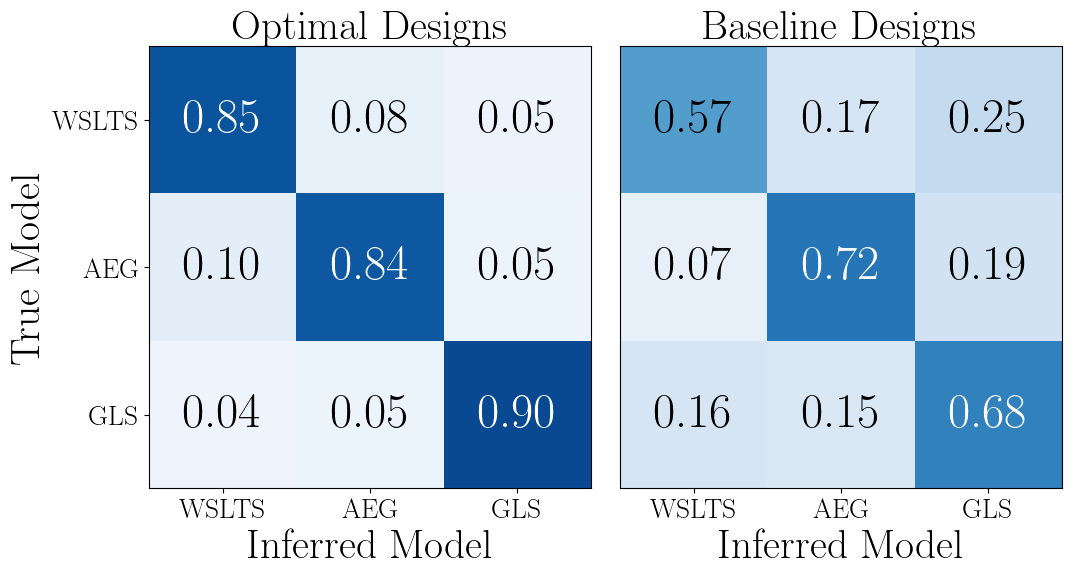

In [10]:
fig = plt.figure(figsize=(11, 6))

ax1 = fig.add_subplot(121)
fig, ax1, _, posts_md_opt_mean, conf_opt = plot_confusion_matrix_post(
    posts_md_opt, fig, ax1, num_decimals=2, colorbar=False, numsize=35, cmap='Blues', mode='conf')
ax1.set_ylabel('True Model', size=30)
ax1.set_xlabel('Inferred Model', size=30)
ax1.set_title('Optimal Designs', size=30)
ax1.set_xticklabels(['WSLTS','AEG','GLS'], size=20)
ax1.set_yticklabels(['GLS','AEG','WSLTS'], size=20)

ax2 = fig.add_subplot(122)
fig, ax2, _, posts_md_base_mean, conf_base = plot_confusion_matrix_post(
    posts_md_base, fig, ax2, num_decimals=2, colorbar=False, numsize=35, cmap='Blues', mode='conf')
ax2.set_xlabel('Inferred Model', size=30)
ax2.set_title('Baseline Designs', size=30)
ax2.set_yticks([])
ax2.set_xticklabels(['WSLTS','AEG','GLS'], size=20)

plt.tight_layout();

# Simulation Study: Parameter Estimation

## Load in the trained models

In [11]:
# baseline designs from literature (randomly sampled from a Beta(2, 2) distribution)
d1 = [0.58885538, 0.61553583, 0.43753505]
d2 = [0.38271915, 0.55060623, 0.07480919]
d3 = [0.61712785, 0.57840447, 0.474485]
d_pe_base = numpy.array([d1, d2, d3]).reshape(-1, 1)

### WSLTS models

In [12]:
# these are the original hyper-parameters the optimal and naive models have been trained with
modelparams_pe_wslts = {
    # model parameters
    'batchsize': 512,
    'layers': 2,  # number of hidden layers for critic
    'hidden': [64, 32],  # number of hidden units for critic
    # training parameters
    'lr': 1e-3,
    'weight_decay': 1e-4,
    'num_epochs': 400,
    'num_workers': 0,
    'scheduler': 'plateau',
    'plateau_factor': 0.5,
    'plateau_patience': 25,
    # summary stats parameters
    'num_measurements': 3,  # number of blocks of trials
    'summary_stats': True,
    'summ_L': 2,  # number of hidden layers for each summ head
    'summ_H': [64, 32],  # number of hidden units for each summ head
    'summ_out': 8,  # output dimensions of summary stats
}

In [13]:
# PE WSLTS optimal designs
d1 = [1, 1, 0]
d2 = [1, 0, 1]
d3 = [0, 1, 0]
d_pe_wslts_opt = numpy.array([d1, d2, d3]).reshape(-1, 1)

In [14]:
model_pe_wslts_optimal, model_summ_pe_wslts_optimal = load_trained_models(
    modelparams_pe_wslts,
    filepath_FC='../data/models/pe_wslts_model_trained_optimal_ensemble_new_repeat0.pt',
    filepath_Summ='../data/models/pe_wslts_model_summ_trained_optimal_ensemble_new_repeat0.pt',
    dim1=3
)

In [15]:
model_pe_wslts_base, model_summ_pe_wslts_base = load_trained_models(
    modelparams_pe_wslts,
    filepath_FC='../data/models/pe_wslts_model_trained_base.pt',
    filepath_Summ='../data/models/pe_wslts_model_summ_trained_base.pt',
    dim1=3
)

### AEG models

In [16]:
# these are the original hyper-parameters the optimal and naive models have been trained with
modelparams_pe_aeg = {
    # model parameters
    'batchsize': 512,
    'layers': 2,  # number of hidden layers for critic
    'hidden': [64, 32],  # number of hidden units for critic
    # training parameters
    'lr': 1e-3,
    'weight_decay': 1e-2,
    'num_epochs': 300,
    'num_workers': 0,
    'scheduler': 'plateau',
    'plateau_factor': 0.5,
    'plateau_patience': 25,
    # summary stats parameters
    'num_measurements': 3,  # number of blocks of trials
    'summary_stats': True,
    'summ_L': 2,  # number of hidden layers for each summ head
    'summ_H': [64, 32],  # number of hidden units for each summ head
    'summ_out': 6,  # output dimensions of summary stats
}

In [17]:
# PE AEG optimal designs
d1 = [1, 0, 0]
d2 = [0, 0, 1]
d3 = [1, 0, 1]
d_pe_aeg_opt = numpy.array([d1, d2, d3]).reshape(-1, 1)

In [18]:
model_pe_aeg_optimal, model_summ_pe_aeg_optimal = load_trained_models(
    modelparams_pe_aeg,
    filepath_FC='../data/models/pe_aeg_model_trained_optimal_ensemble_new_repeat0.pt',
    filepath_Summ='../data/models/pe_aeg_model_summ_trained_optimal_ensemble_new_repeat0.pt',
    dim1=2
)

In [19]:
model_pe_aeg_base, model_summ_pe_aeg_base = load_trained_models(
    modelparams_pe_aeg,
    filepath_FC='../data/models/pe_aeg_model_trained_base.pt',
    filepath_Summ='../data/models/pe_aeg_model_summ_trained_base.pt',
    dim1=2
)

### GLS models

In [20]:
# these are the original hyper-parameters the optimal and naive models have been trained with
modelparams_pe_gls = {
    # model parameters
    'batchsize': 512,
    'layers': 2,  # number of hidden layers for critic
    'hidden': [64, 32],  # number of hidden units for critic
    # training parameters
    'lr': 1e-3,
    'weight_decay': 1e-3,
    'num_epochs': 300,
    'num_workers': 0,
    'scheduler': 'plateau',
    'plateau_factor': 0.5,
    'plateau_patience': 25,
    # summary stats parameters
    'num_measurements': 3,  # number of blocks of trials
    'summary_stats': True,
    'summ_L': 2,  # number of hidden layers for each summ head
    'summ_H': [64, 32],  # number of hidden units for each summ head
    'summ_out': 8,  # output dimensions of summary stats
}

In [21]:
# PE GLS optimal designs
d1 = [0, 1, 0]
d2 = [0, 0, 1]
d3 = [0, 0, 1]
d_pe_gls_opt = numpy.array([d1, d2, d3]).reshape(-1, 1)

In [22]:
model_pe_gls_optimal, model_summ_pe_gls_optimal = load_trained_models(
    modelparams_pe_gls,
    filepath_FC='../data/models/pe_gls_model_trained_optimal_ensemble_new_repeat0.pt',
    filepath_Summ='../data/models/pe_gls_model_summ_trained_optimal_ensemble_new_repeat0.pt',
    dim1=5
)

In [23]:
model_pe_gls_base, model_summ_pe_gls_base = load_trained_models(
    modelparams_pe_gls,
    filepath_FC='../data/models/pe_gls_model_trained_base.pt',
    filepath_Summ='../data/models/pe_gls_model_summ_trained_base.pt',
    dim1=5
)

## Compute posterior distributions

In [24]:
# define prior densities
prior_th0 = lambda x: numpy.ones(len(x))
prior_th1 = lambda x: numpy.ones(len(x))
prior_th2 = lambda x: lognorm(s=1, loc=0).pdf(x)

prior_density_all = [prior_th0, prior_th1, prior_th2]

### WSLTS posteriors

In [25]:
# generate samples from the prior
prior_0 = sim_bandit_prior(50_000, prior='uninformed', simmodel=0)

# bins for plotting
BINS=100
bins_0 = numpy.linspace(0, 1, BINS)
bins_1 = numpy.linspace(0, 1, BINS)
bins_2 = numpy.linspace(0.01, 5, BINS)
bins_all_0 = [bins_0, bins_1, bins_2]

In [26]:
# compute histograms of posterior samples for several synthetic observations; Optimal
post_hists_pe_wslts_opt, bins_pe_wslts = get_pe_posteriors_histograms(
    d_pe_wslts_opt,
    model_pe_wslts_optimal,
    model_summ_pe_wslts_optimal,
    prior_0,
    bins_all_0,
    simmodel=0,
    num_repeats=100
)

100%|██████████| 100/100 [02:57<00:00,  1.78s/it]


In [27]:
# compute histograms of posterior samples for several synthetic observations; Baseline
post_hists_pe_wslts_base, bins_pe_wslts = get_pe_posteriors_histograms(
    d_pe_base,
    model_pe_wslts_base,
    model_summ_pe_wslts_base,
    prior_0,
    bins_all_0,
    simmodel=0,
    num_repeats=100
)

100%|██████████| 100/100 [02:58<00:00,  1.78s/it]


In [28]:
# compute kernel density estimates of these distributions via resampling; Optimal
post_kde_pe_wslts_opt, spaces_pe_wslts = get_pe_posteriors_densities(
    post_hists_pe_wslts_opt,
    bins_pe_wslts,
    prior_0,
    simmodel=0,
    grid_size=100,
    resample_size=10_000
)

In [29]:
# compute kernel density estimates of these distributions via resampling; Baseline
post_kde_pe_wslts_base, spaces_pe_wslts = get_pe_posteriors_densities(
    post_hists_pe_wslts_base,
    bins_pe_wslts,
    prior_0,
    simmodel=0,
    grid_size=100,
    resample_size=10_000
)

### AEG posteriors

In [30]:
# generate samples from the prior
prior_1 = sim_bandit_prior(50_000, prior='uninformed', simmodel=1)

# prior densities
prior_th0 = lambda x: numpy.ones(len(x))
prior_th1 = lambda x: numpy.ones(len(x))
prior_density_all_1 = [prior_th0, prior_th1]

# bins for plotting
BINS=100
bins_0 = numpy.linspace(0, 1, BINS)
bins_1 = numpy.linspace(0, 1, BINS)
bins_all_1 = [bins_0, bins_1]

In [31]:
# compute histograms of posterior samples for several synthetic observations; Optimal
post_hists_pe_aeg_opt, bins_pe_aeg = get_pe_posteriors_histograms(
    d_pe_aeg_opt,
    model_pe_aeg_optimal,
    model_summ_pe_aeg_optimal,
    prior_1,
    bins_all_1,
    simmodel=1,
    num_repeats=100
)

100%|██████████| 100/100 [02:54<00:00,  1.74s/it]


In [32]:
# compute histograms of posterior samples for several synthetic observations; Baseline
post_hists_pe_aeg_base, bins_pe_aeg = get_pe_posteriors_histograms(
    d_pe_base,
    model_pe_aeg_base,
    model_summ_pe_aeg_base,
    prior_1,
    bins_all_1,
    simmodel=1,
    num_repeats=100
)

100%|██████████| 100/100 [03:04<00:00,  1.84s/it]


In [33]:
# compute kernel density estimates of these distributions via resampling; Optimal
post_kde_pe_aeg_opt, spaces_pe_aeg = get_pe_posteriors_densities(
    post_hists_pe_aeg_opt,
    bins_pe_aeg,
    prior_1,
    simmodel=1,
    grid_size=100,
    resample_size=10_000
)

In [34]:
# compute kernel density estimates of these distributions via resampling; Baseline
post_kde_pe_aeg_base, spaces_pe_aeg = get_pe_posteriors_densities(
    post_hists_pe_aeg_base,
    bins_pe_aeg,
    prior_1,
    simmodel=1,
    grid_size=100,
    resample_size=10_000
)

### GLS posteriors

In [35]:
# generate samples from the prior
prior_2 = sim_bandit_prior(50_000, prior='uninformed', simmodel=2)

# prior densities
prior_th0 = lambda x: numpy.ones(len(x))
prior_th1 = lambda x: numpy.ones(len(x))
prior_th2 = lambda x: numpy.ones(len(x))
prior_th3 = lambda x: numpy.ones(len(x))
prior_th4 = lambda x: numpy.ones(len(x))
prior_density_all_2 = [prior_th0, prior_th1, prior_th2, prior_th3, prior_th4]

# bins for plotting
BINS=50
bins_0 = numpy.linspace(0, 1, BINS)
bins_1 = numpy.linspace(0, 1, BINS)
bins_2 = numpy.linspace(0, 1, BINS)
bins_3 = numpy.linspace(0, 1, BINS)
bins_4 = numpy.linspace(0, 1, BINS)
bins_all_2 = [bins_0, bins_1, bins_2, bins_3, bins_4]

In [36]:
# compute histograms of posterior samples for several synthetic observations; Optimal
post_hists_pe_gls_opt, bins_pe_gls = get_pe_posteriors_histograms(
    d_pe_gls_opt,
    model_pe_gls_optimal,
    model_summ_pe_gls_optimal,
    prior_2,
    bins_all_2,
    simmodel=2,
    num_repeats=100,
)

100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


In [37]:
# compute histograms of posterior samples for several synthetic observations; Baseline
post_hists_pe_gls_base, bins_pe_gls = get_pe_posteriors_histograms(
    d_pe_base,
    model_pe_gls_base,
    model_summ_pe_gls_base,
    prior_2,
    bins_all_2,
    simmodel=2,
    num_repeats=100
)

100%|██████████| 100/100 [03:27<00:00,  2.07s/it]


In [38]:
# compute kernel density estimates of these distributions via resampling; Optimal
post_kde_pe_gls_opt, spaces_pe_gls = get_pe_posteriors_densities(
    post_hists_pe_gls_opt,
    bins_pe_gls,
    prior_2,
    simmodel=2,
    grid_size=50,
    resample_size=10_000
)

In [39]:
# compute kernel density estimates of these distributions via resampling; Baseline
post_kde_pe_gls_base, spaces_pe_gls = get_pe_posteriors_densities(
    post_hists_pe_gls_base,
    bins_pe_gls,
    prior_2,
    simmodel=2,
    grid_size=50,
    resample_size=10_000
)

## Plot Posterior Distributions

### WSLTS

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


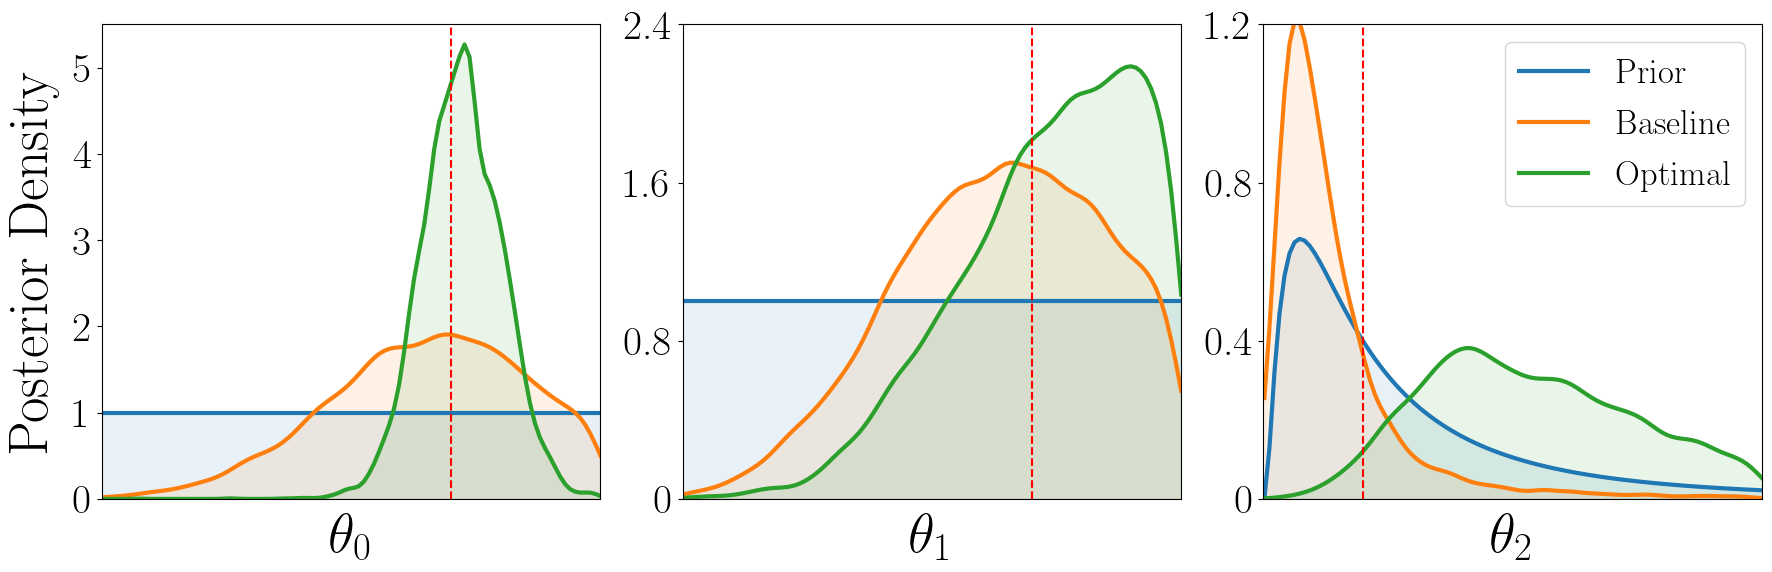

In [40]:
fig = plt.figure(figsize=(18, 6))

true_theta = [0.7, 0.7, 1]

axes = list()
for idx in range(len(true_theta)):
    
    # load in the densities
    kde_opt = post_kde_pe_wslts_opt[idx]
    kde_base = post_kde_pe_wslts_base[idx]
    x = spaces_pe_wslts[idx]
    
    ax = fig.add_subplot(1,3,idx+1)

    ax.plot(x, prior_density_all[idx](x), c=cycle[0], lw=3, label='Prior')
    ax.fill_between(x, prior_density_all[idx](x), color=cycle[0], alpha=0.1)
    ax.plot(x, kde_base, c=cycle[1], lw=3, label='Baseline')
    ax.fill_between(x, kde_base, color=cycle[1], alpha=0.1)
    ax.plot(x, kde_opt, c=cycle[2], lw=3, label='Optimal')
    ax.fill_between(x, kde_opt, color=cycle[2], alpha=0.1)
    ax.axvline(true_theta[idx], ls='--', c='r')
    ax.grid(False) # , ls='--')
    ax.set_xlabel(r'$\theta_{}$'.format(idx), size=40, labelpad=10)
    ax.tick_params(labelsize=20)
    ax.grid(False)
    ax.tick_params(labelsize=20)
    axes.append(ax)
    

# first parameter
axes[0].set_ylim([0, 5.5])
axes[0].set_xlim([0, 1])
axes[0].set_yticks([0, 1, 2, 3, 4, 5])
axes[0].set_yticklabels([0, 1, 2, 3, 4, 5], size=30)
axes[0].set_xticks([]) #[0, 0.5, 1])
axes[0].set_xticklabels([]) #[0, 0.5, 1], size=30)
axes[0].set_ylabel('Posterior Density', size=40, labelpad=10)
# second parameter
axes[1].set_ylim([0, 2.4])
axes[1].set_xlim([0, 1])
axes[1].set_yticks([0, 0.8, 1.6, 2.4])
axes[1].set_yticklabels([0, 0.8, 1.6, 2.4], size=30)
axes[1].set_xticks([]) #[0, 0.5, 1])
axes[1].set_xticklabels([]) #[0, 0.5, 1], size=30)
# third parameter
axes[2].set_ylim([0, 1.2])
axes[2].set_xlim([0, 5])
axes[2].set_yticks([0, 0.4, 0.8, 1.2])
axes[2].set_yticklabels([0, 0.4, 0.8, 1.2], size=30)
axes[2].set_xticks([]) #[0, 2.5, 5])
axes[2].set_xticklabels([]) #[0, 2.5, 5], size=30)
axes[2].legend(loc='upper right', prop={'size': 25})

plt.tight_layout();

### AEG

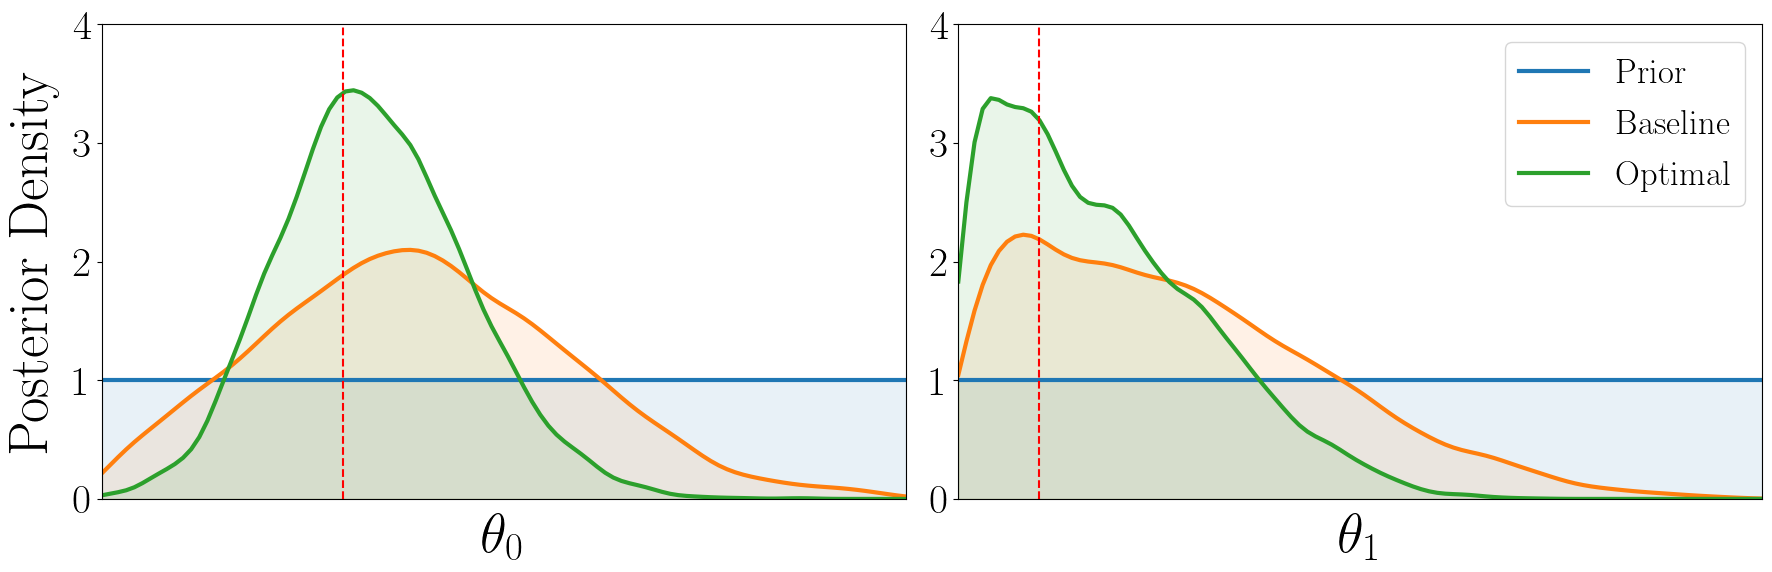

In [41]:
fig = plt.figure(figsize=(18, 6))

true_theta = [0.3, 0.1]

axes = list()
for idx in range(len(true_theta)):
    
    # load in the densities
    kde_opt = post_kde_pe_aeg_opt[idx]
    kde_base = post_kde_pe_aeg_base[idx]
    x = spaces_pe_aeg[idx]
    
    ax = fig.add_subplot(1,2,idx+1)

    ax.plot(x, prior_density_all[idx](x), c=cycle[0], lw=3, label='Prior')
    ax.fill_between(x, prior_density_all[idx](x), color=cycle[0], alpha=0.1)
    ax.plot(x, kde_base, c=cycle[1], lw=3, label='Baseline')
    ax.fill_between(x, kde_base, color=cycle[1], alpha=0.1)
    ax.plot(x, kde_opt, c=cycle[2], lw=3, label='Optimal')
    ax.fill_between(x, kde_opt, color=cycle[2], alpha=0.1)
    ax.axvline(true_theta[idx], ls='--', c='r')
    ax.grid(False) # , ls='--')
    ax.set_xlabel(r'$\theta_{}$'.format(idx), size=40, labelpad=10)
    ax.tick_params(labelsize=20)
    ax.grid(False)
    ax.tick_params(labelsize=20)
    axes.append(ax)
    

# first parameter
axes[0].set_ylim([0, 4])
axes[0].set_xlim([0, 1])
axes[0].set_yticks([0, 1, 2, 3, 4])
axes[0].set_yticklabels([0, 1, 2, 3, 4], size=30)
axes[0].set_xticks([]) #[0, 0.5, 1])
axes[0].set_xticklabels([]) #[0, 0.5, 1], size=30)
axes[0].set_ylabel('Posterior Density', size=40, labelpad=10)
# second parameter
axes[1].set_ylim([0, 4])
axes[1].set_xlim([0, 1])
axes[1].set_yticks([0, 1, 2, 3, 4])
axes[1].set_yticklabels([0, 1, 2, 3, 4], size=30)
axes[1].set_xticks([]) #[0, 2.5, 5])
axes[1].set_xticklabels([]) #[0, 2.5, 5], size=30)
axes[1].legend(loc='upper right', prop={'size': 25})

plt.tight_layout();

### GLS

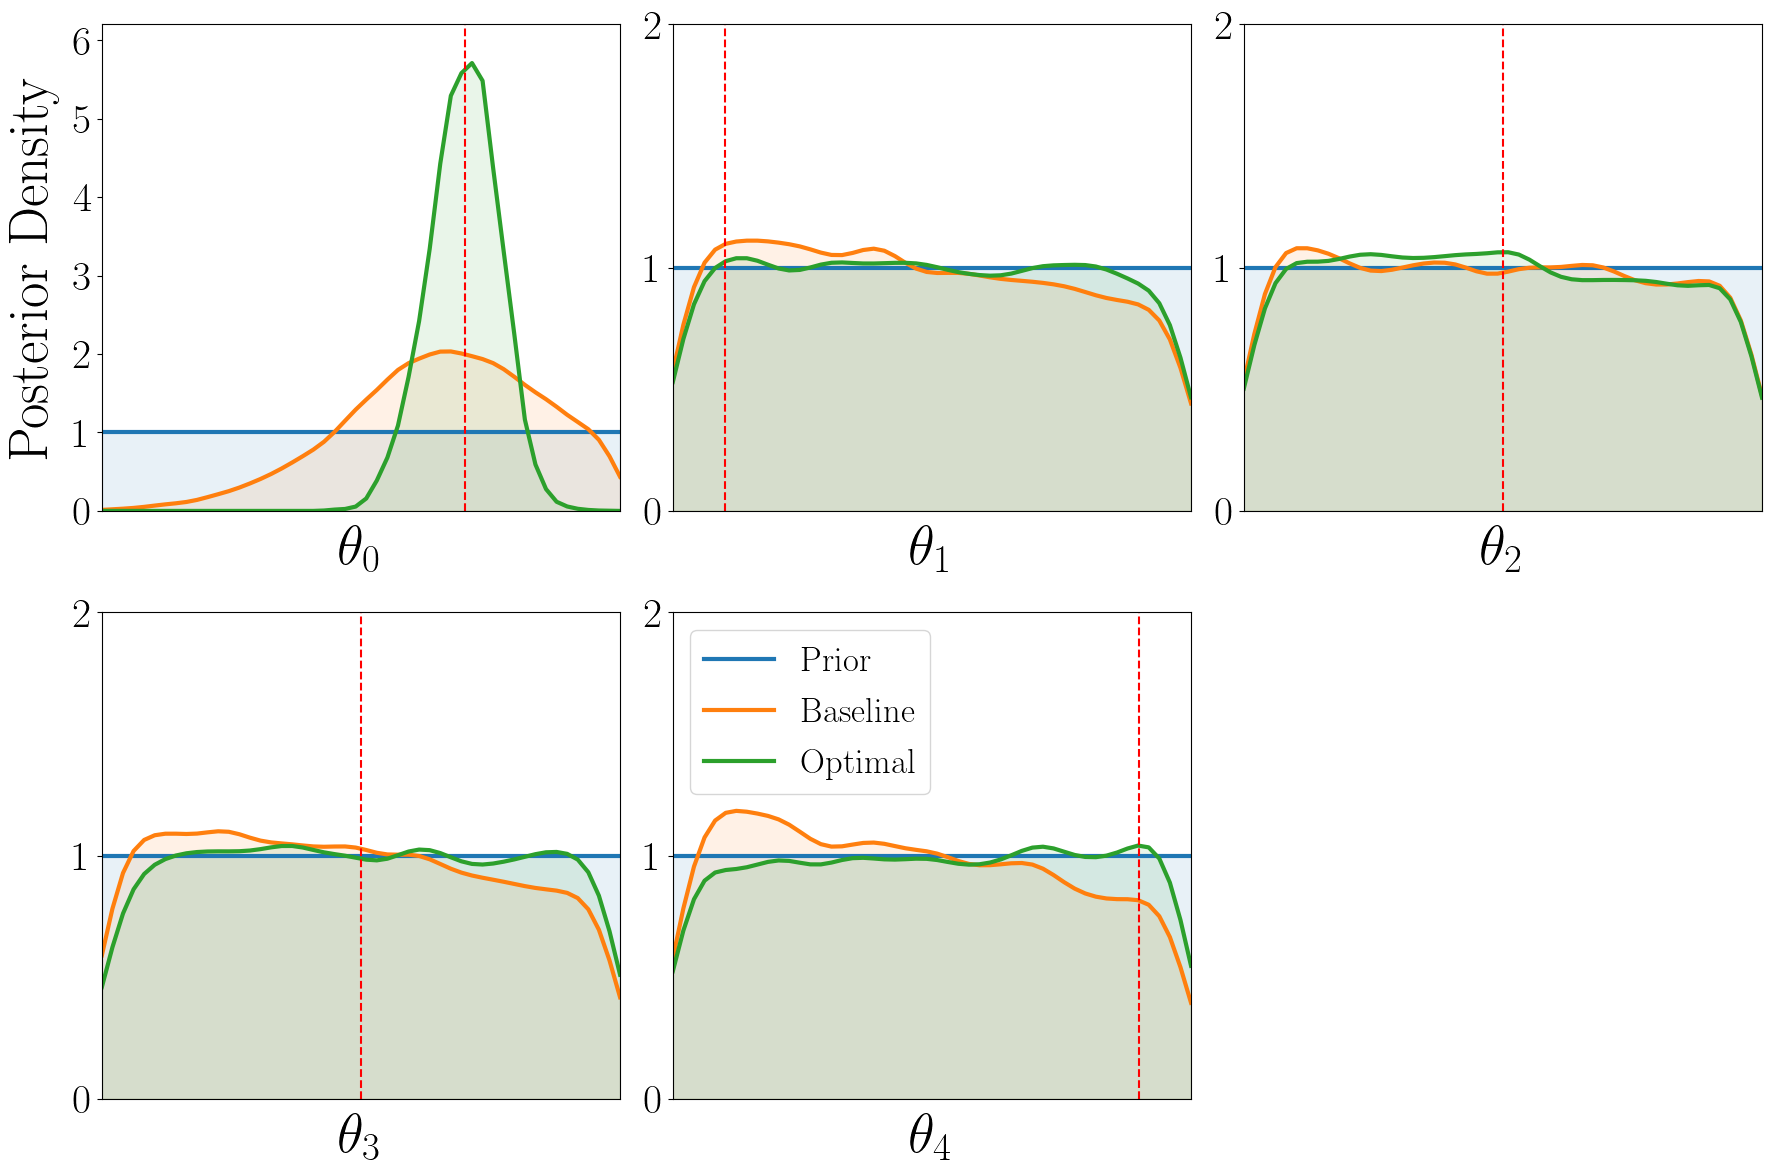

In [42]:
fig = plt.figure(figsize=(18, 12))

true_theta = [0.7, 0.1, 0.5, 0.5, 0.9]

axes = list()
for idx in range(len(true_theta)):
    
    # load in the densities
    kde_opt = post_kde_pe_gls_opt[idx]
    kde_base = post_kde_pe_gls_base[idx]
    x = spaces_pe_gls[idx]
    
    ax = fig.add_subplot(2,3,idx+1)

    ax.plot(x, prior_density_all_2[idx](x), c=cycle[0], lw=3, label='Prior')
    ax.fill_between(x, prior_density_all_2[idx](x), color=cycle[0], alpha=0.1)
    ax.plot(x, kde_base, c=cycle[1], lw=3, label='Baseline')
    ax.fill_between(x, kde_base, color=cycle[1], alpha=0.1)
    ax.plot(x, kde_opt, c=cycle[2], lw=3, label='Optimal')
    ax.fill_between(x, kde_opt, color=cycle[2], alpha=0.1)
    ax.axvline(true_theta[idx], ls='--', c='r')
    ax.grid(False) # , ls='--')
    ax.set_xlabel(r'$\theta_{}$'.format(idx), size=40, labelpad=10)
    ax.tick_params(labelsize=20)
    ax.grid(False)
    ax.tick_params(labelsize=20)
    axes.append(ax)
    

# first parameter
axes[0].set_ylim([0, 6.2])
axes[0].set_xlim([0, 1])
axes[0].set_yticks([0, 1, 2, 3, 4, 5, 6])
axes[0].set_yticklabels([0, 1, 2, 3, 4, 5, 6], size=30)
axes[0].set_xticks([]) #[0, 0.5, 1])
axes[0].set_xticklabels([]) #[0, 0.5, 1], size=30)
axes[0].set_ylabel('Posterior Density', size=40, labelpad=10)
# second parameter
axes[1].set_ylim([0, 2])
axes[1].set_xlim([0, 1])
axes[1].set_yticks([0, 1, 2])
axes[1].set_yticklabels([0, 1, 2], size=30)
axes[1].set_xticks([]) #[0, 0.5, 1])
axes[1].set_xticklabels([]) #[0, 0.5, 1], size=30)
# third parameter
axes[2].set_ylim([0, 2])
axes[2].set_xlim([0, 1])
axes[2].set_yticks([0, 1, 2])
axes[2].set_yticklabels([0, 1, 2], size=30)
axes[2].set_xticks([]) #[0, 2.5, 5])
axes[2].set_xticklabels([]) #[0, 2.5, 5], size=30)
# fourth parameter
axes[3].set_ylim([0, 2])
axes[3].set_xlim([0, 1])
axes[3].set_yticks([0, 1, 2])
axes[3].set_yticklabels([0, 1, 2], size=30)
axes[3].set_xticks([]) #[0, 2.5, 5])
axes[3].set_xticklabels([]) #[0, 2.5, 5], size=30)
# fifth parameter
axes[4].set_ylim([0, 2])
axes[4].set_xlim([0, 1])
axes[4].set_yticks([0, 1, 2])
axes[4].set_yticklabels([0, 1, 2], size=30)
axes[4].set_xticks([]) #[0, 2.5, 5])
axes[4].set_xticklabels([]) #[0, 2.5, 5], size=30)
axes[4].legend(loc='upper left', prop={'size': 25})

plt.tight_layout();